# Visualization of evolution graphes

In [14]:
%matplotlib widget
#%matplotlib inline
import datetime
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import operator
import copy
from utilefunc.get_palette import get_palette
from evolution_graph import evolution_graph_ndvi
from evolution_graph import evolution_graph_synopsis

In [8]:
# Parameter settings
## segmentation parameters 
scale=5        # controls the number of produced segments as well as their size. Higher scale means less and larger segments. 
sigma=0          # diameter of a Gaussian kernel, used for smoothing the image prior to segmentation.
min_size=5      # minimum size of the segment

## BB selection and graph construction parameters
alpha = 0.4
t1 = 0.1
t2 = 0
direction=1  # 0 : from small to big; 1: from big to small

## general data informations
fields_data_fpath = 'pinnote_anomaly_info/annotations_valid_dates_final.csv'
fields_data = pd.read_csv(fields_data_fpath, sep=';', )
sfd_ids = fields_data['sfd_id'].unique()  # all season field ids to process
data_path = 'data_images_2017_2020/'  # path for image time series, each stocked in a file folder named with the sfd_id

# save paths
save_path_df = 'variables/raster_df/scale_{0}/'.format(scale)
if direction == 0:
    save_path_bb = 'variables/BB_evolution_graph/BB_small2big/scale_{0}_alpha_{1}_t1_{2}_t2_{3}/'.format(scale, alpha, t1, t2)
    save_path_shp = 'variables/sfd_bbs_cover/BB_small2big/scale_{0}_alpha_{1}_t1_{2}_t2_{3}/'.format(scale, alpha, t1, t2)
if direction == 1:
    save_path_bb = 'variables/BB_evolution_graph/BB_big2small/scale_{0}_alpha_{1}_t1_{2}_t2_{3}/'.format(scale, alpha, t1, t2)
    save_path_shp = 'variables/sfd_bbs_cover/BB_big2small/scale_{0}_alpha_{1}_t1_{2}_t2_{3}/'.format(scale, alpha, t1, t2)

In [9]:
#sfd_id_choice = 102424640
sfd_id_choice = 102112829

In [10]:
year_choice = fields_data[fields_data.sfd_id == sfd_id_choice].year.unique()[0]
raster_df = pd.read_pickle(save_path_df+'{0}_{1}_scale_{2}_raster_seg_df.pkl'.format(sfd_id_choice,year_choice,scale))

segments_test = raster_df['segments_fz'].iloc[(raster_df.index >= datetime.datetime(year_choice,1,1)) & (raster_df.index <= datetime.datetime(year_choice,12,31))]
raster_ndvi_numpy_test = raster_df['raster_ndvi_numpy'].iloc[(raster_df.index >= datetime.datetime(year_choice,1,1)) & (raster_df.index <= datetime.datetime(year_choice,12,31))]

bb_final_list = np.load(save_path_bb+'{0}_{1}_scale_{2}_alpha_{3}_t1_{4}_t2_{5}_final_bb.npy'.format(sfd_id_choice,year_choice,scale,alpha,t1,t2), allow_pickle=True)

## Visualize synopsis

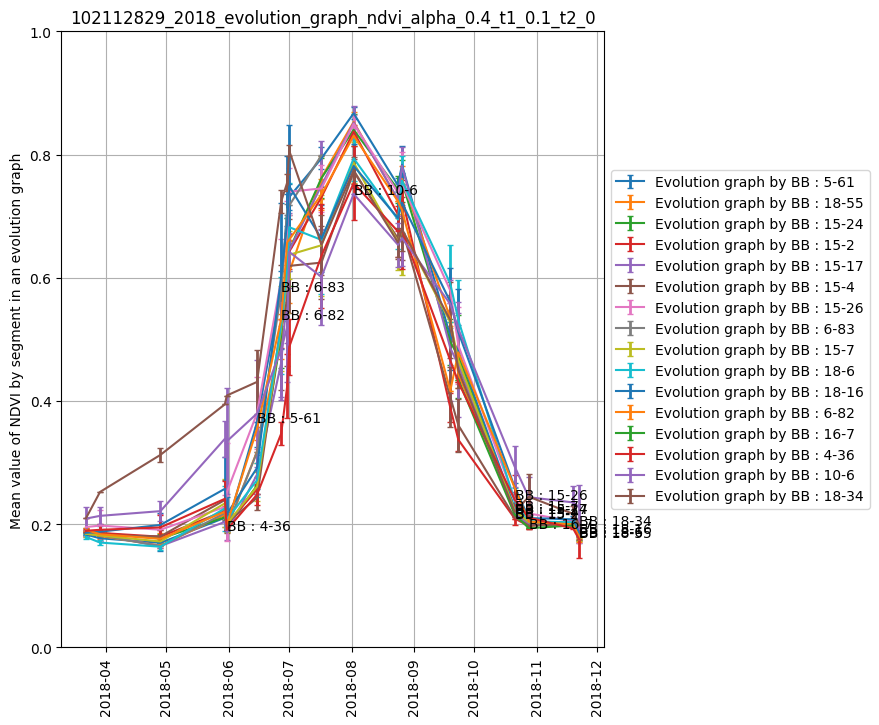

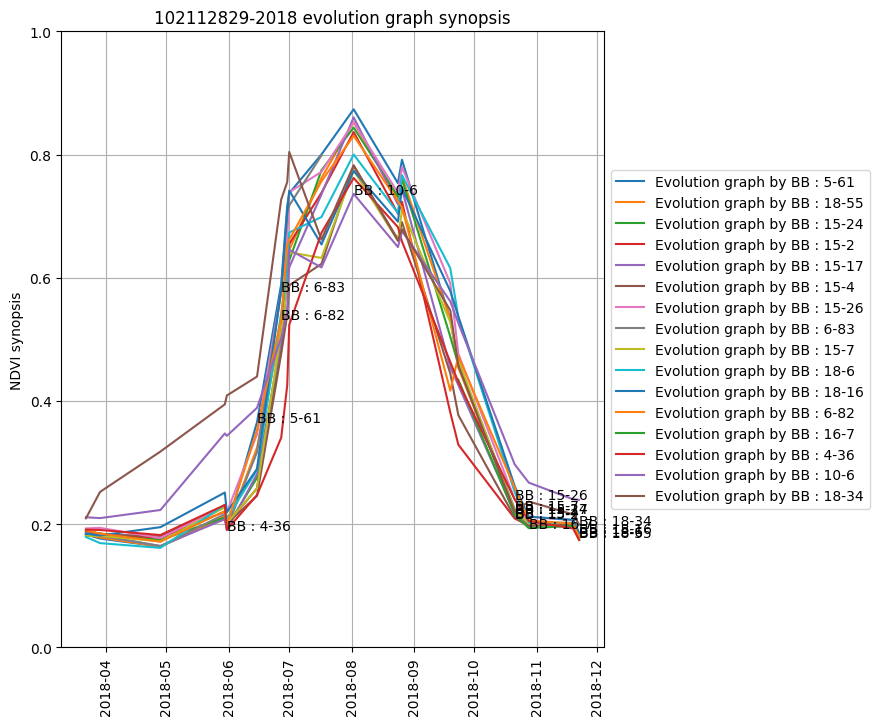

In [11]:
evolution_graph_ndvi(sfd_id_choice, year_choice, bb_final_list, segments_test, raster_ndvi_numpy_test, alpha, t1, t2)
evolution_graph_synopsis(sfd_id_choice, year_choice, bb_final_list, segments_test, raster_ndvi_numpy_test, alpha, t1, t2)

## Visualize temporal coverage of evolution graphes with NDVI values

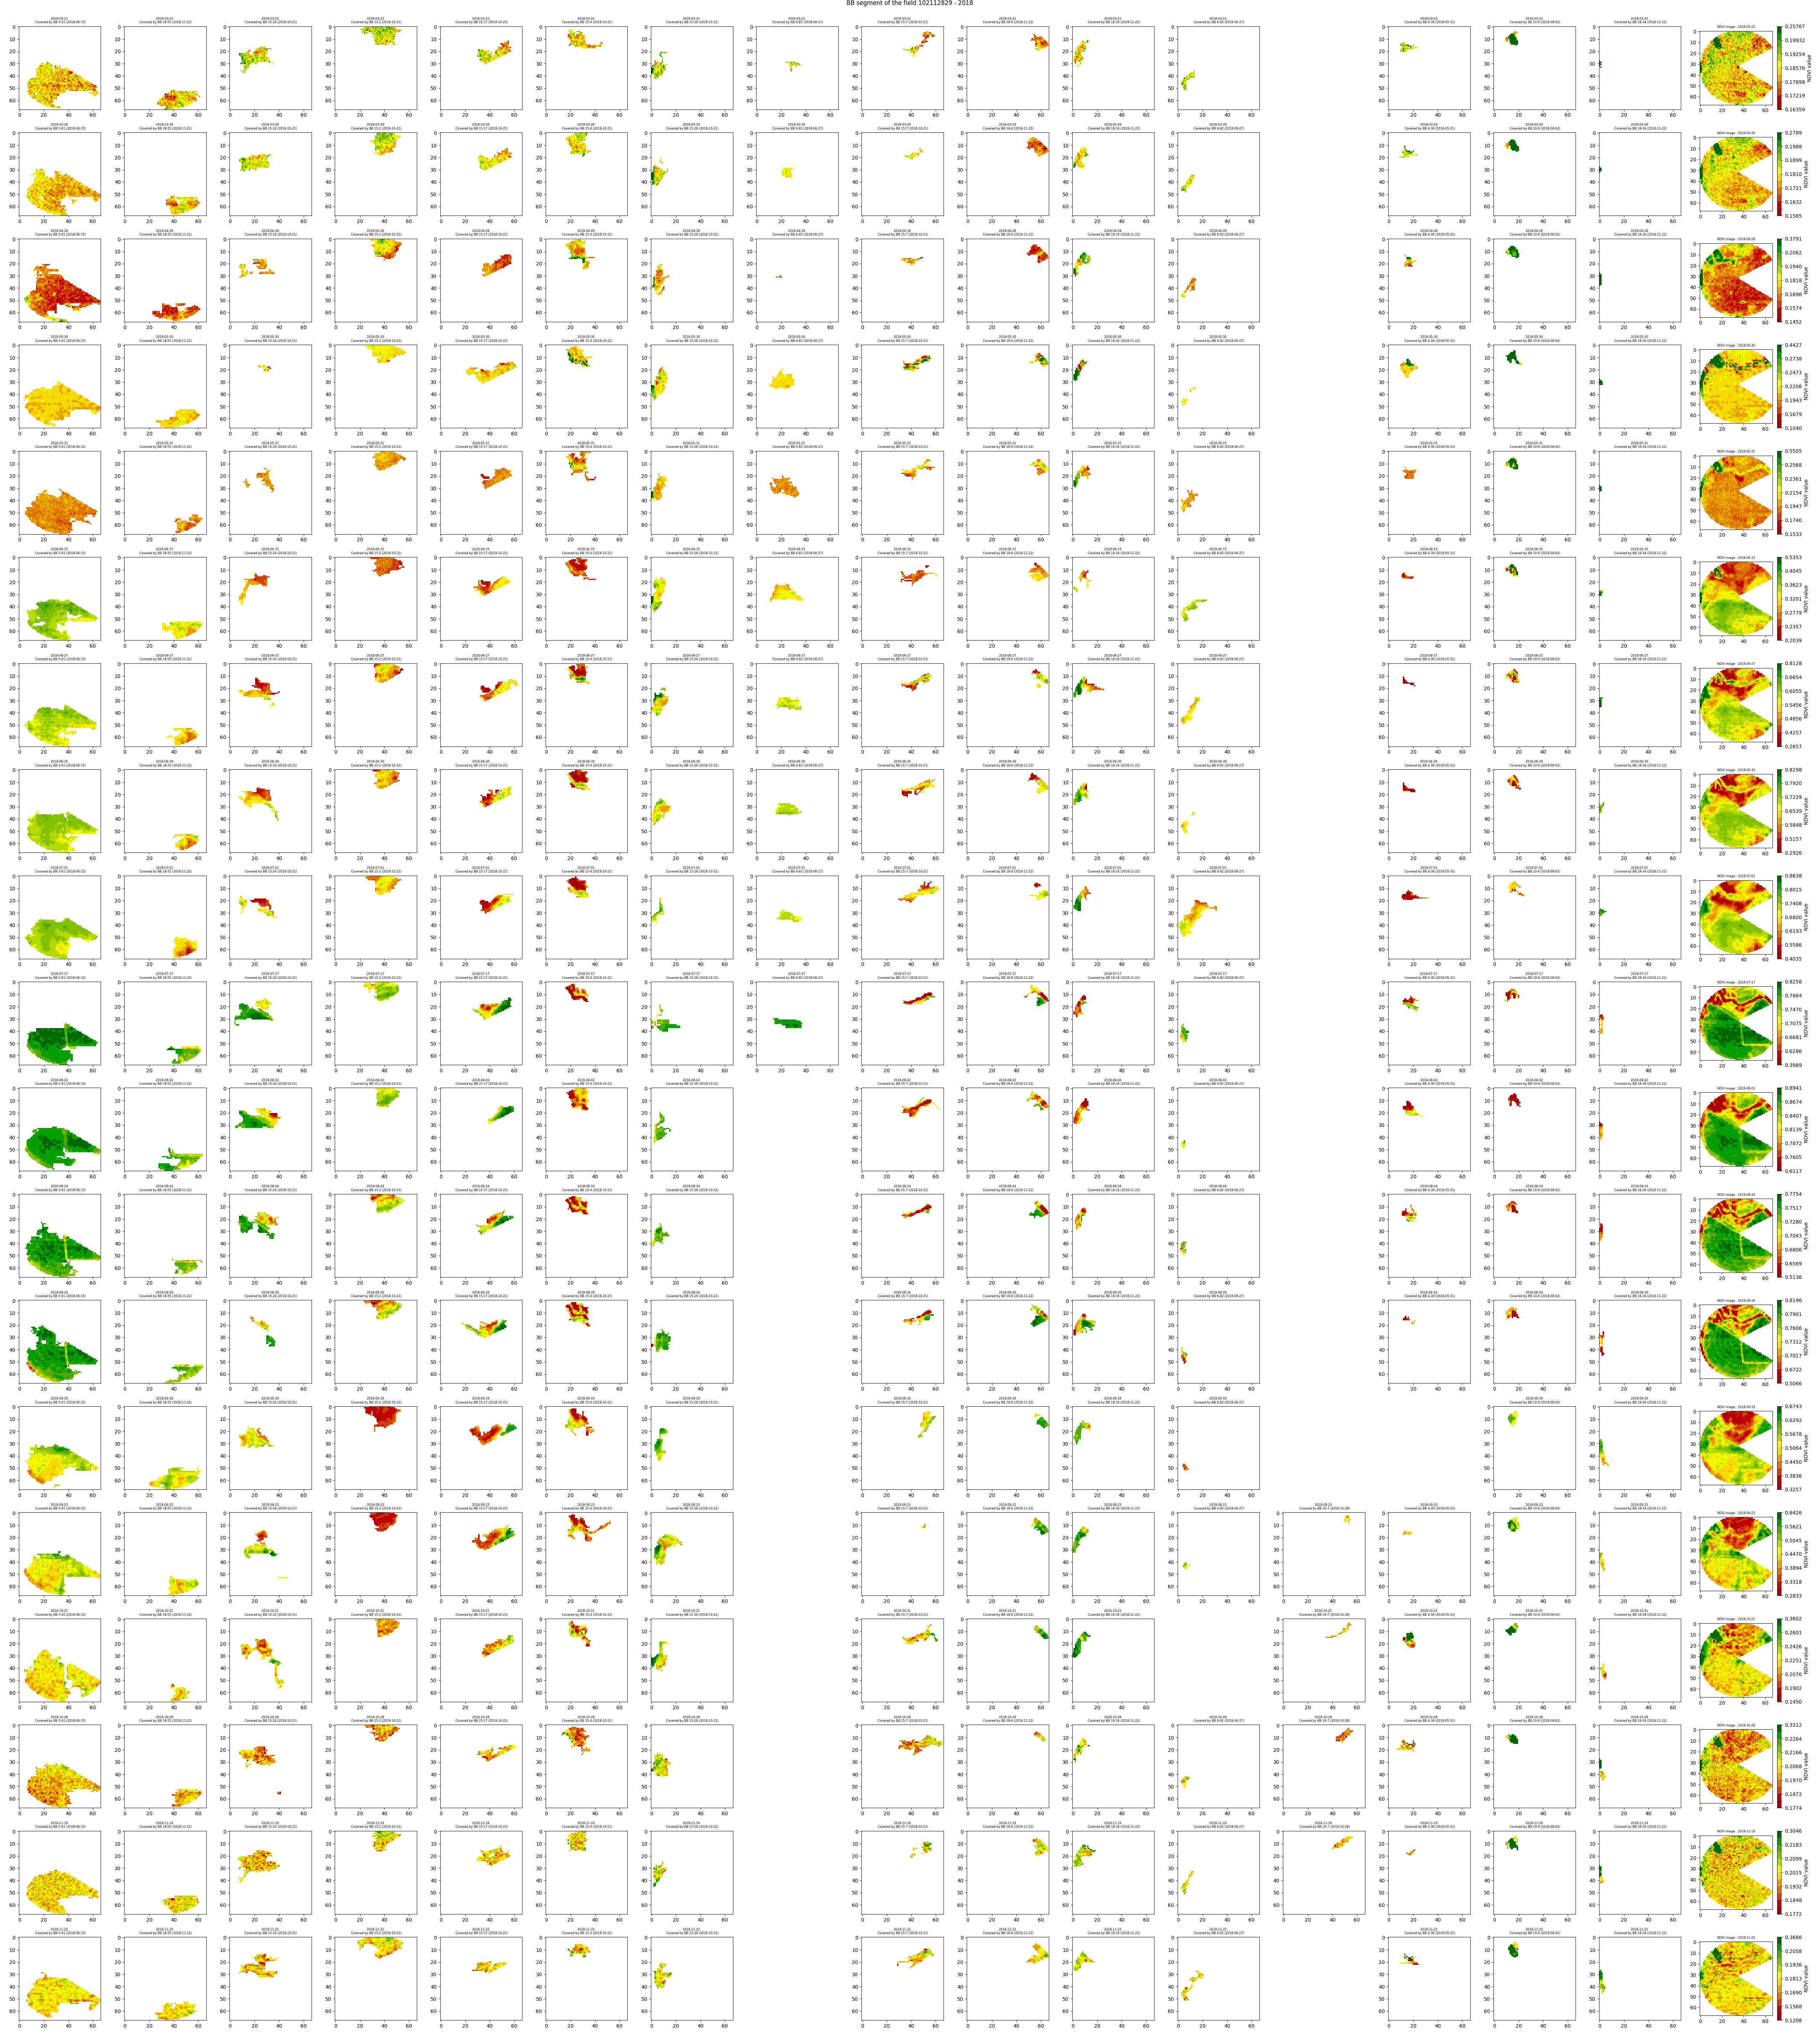

In [15]:
plt.close('all')
fig = plt.figure(figsize=(3*(bb_final_list.shape[0]+1),3*len(segments_test))) #figsize=(20,50))

for j in range(len(segments_test)):
    date_choice = segments_test.index[j].strftime('%Y-%m-%d')
    raster_ndvi_numpy = raster_df.loc[date_choice, 'raster_ndvi_numpy']
    
    plt.subplot(len(segments_test), bb_final_list.shape[0]+1, j*(bb_final_list.shape[0]+1)+bb_final_list.shape[0]+1)
    cmap, norm = get_palette(raster_ndvi_numpy)
    f2 = plt.imshow(raster_ndvi_numpy, cmap=cmap, norm=norm)
    plt.colorbar(f2, label='NDVI value')
    plt.title(f"NDVI image : {date_choice}",fontsize=6)   
        
for i in range(bb_final_list.shape[0]):
    dico_bb = dict()
    for x in bb_final_list[i,4]:
        dico_bb[x[0]] = dico_bb.get(x[0], []) + [x[1]]
    dico_bb[bb_final_list[i,0]] = [bb_final_list[i,1]]
    dico_bb = dict(sorted(dico_bb.items(), key=operator.itemgetter(0)))
    BB_date = segments_test.index[bb_final_list[i,0]].strftime('%Y-%m-%d')

    for idx in range(len(segments_test)):

        date_choice = segments_test.index[idx].strftime('%Y-%m-%d')
        segments_fz = raster_df.loc[date_choice, 'segments_fz']
        raster_ndvi_numpy = raster_df.loc[date_choice, 'raster_ndvi_numpy']
        bb_ndvi = copy.deepcopy(raster_ndvi_numpy)
        coordinate = np.ma.zeros(segments_fz.shape)

        if idx in dico_bb.keys():
            for ind in dico_bb[idx]:
                coordinate.mask += (segments_fz == ind)
            bb_ndvi.mask = bb_ndvi.mask + ~(coordinate.mask)

            title = f"{date_choice} \n Covered by BB {bb_final_list[i,0]}-{bb_final_list[i,1]} ({BB_date})"
            if np.all(bb_ndvi.mask):
                title = f"{date_choice} \n Totally covered by BB {bb_final_list[i,0]}-{bb_final_list[i,1]} ({BB_date})"
                bb_ndvi.mask = raster_ndvi_numpy.mask
            plt.subplot(len(segments_test),bb_final_list.shape[0]+1, idx*(bb_final_list.shape[0]+1)+i+1)
            cmap, norm = get_palette(raster_ndvi_numpy)
            f = plt.imshow(bb_ndvi, cmap=cmap, norm=norm)
            plt.title(title, fontsize=6, y=1.0)

plt.suptitle(f'BB segment of the field {sfd_id_choice} - {year_choice}', y=1)        
plt.tight_layout()
# plt.savefig(f'image_results/evolution_graph/scale_{scale}_alpha_{alpha}_t1_{t1}_t2_{t2}/{sfd_id_choice}_{year_choice}_evolution_graph_alpha_{alpha}_t1_{t1}_t2_{t2}.png', format='png')
plt.show()


## Visualize temporal coverage of evolution graphes

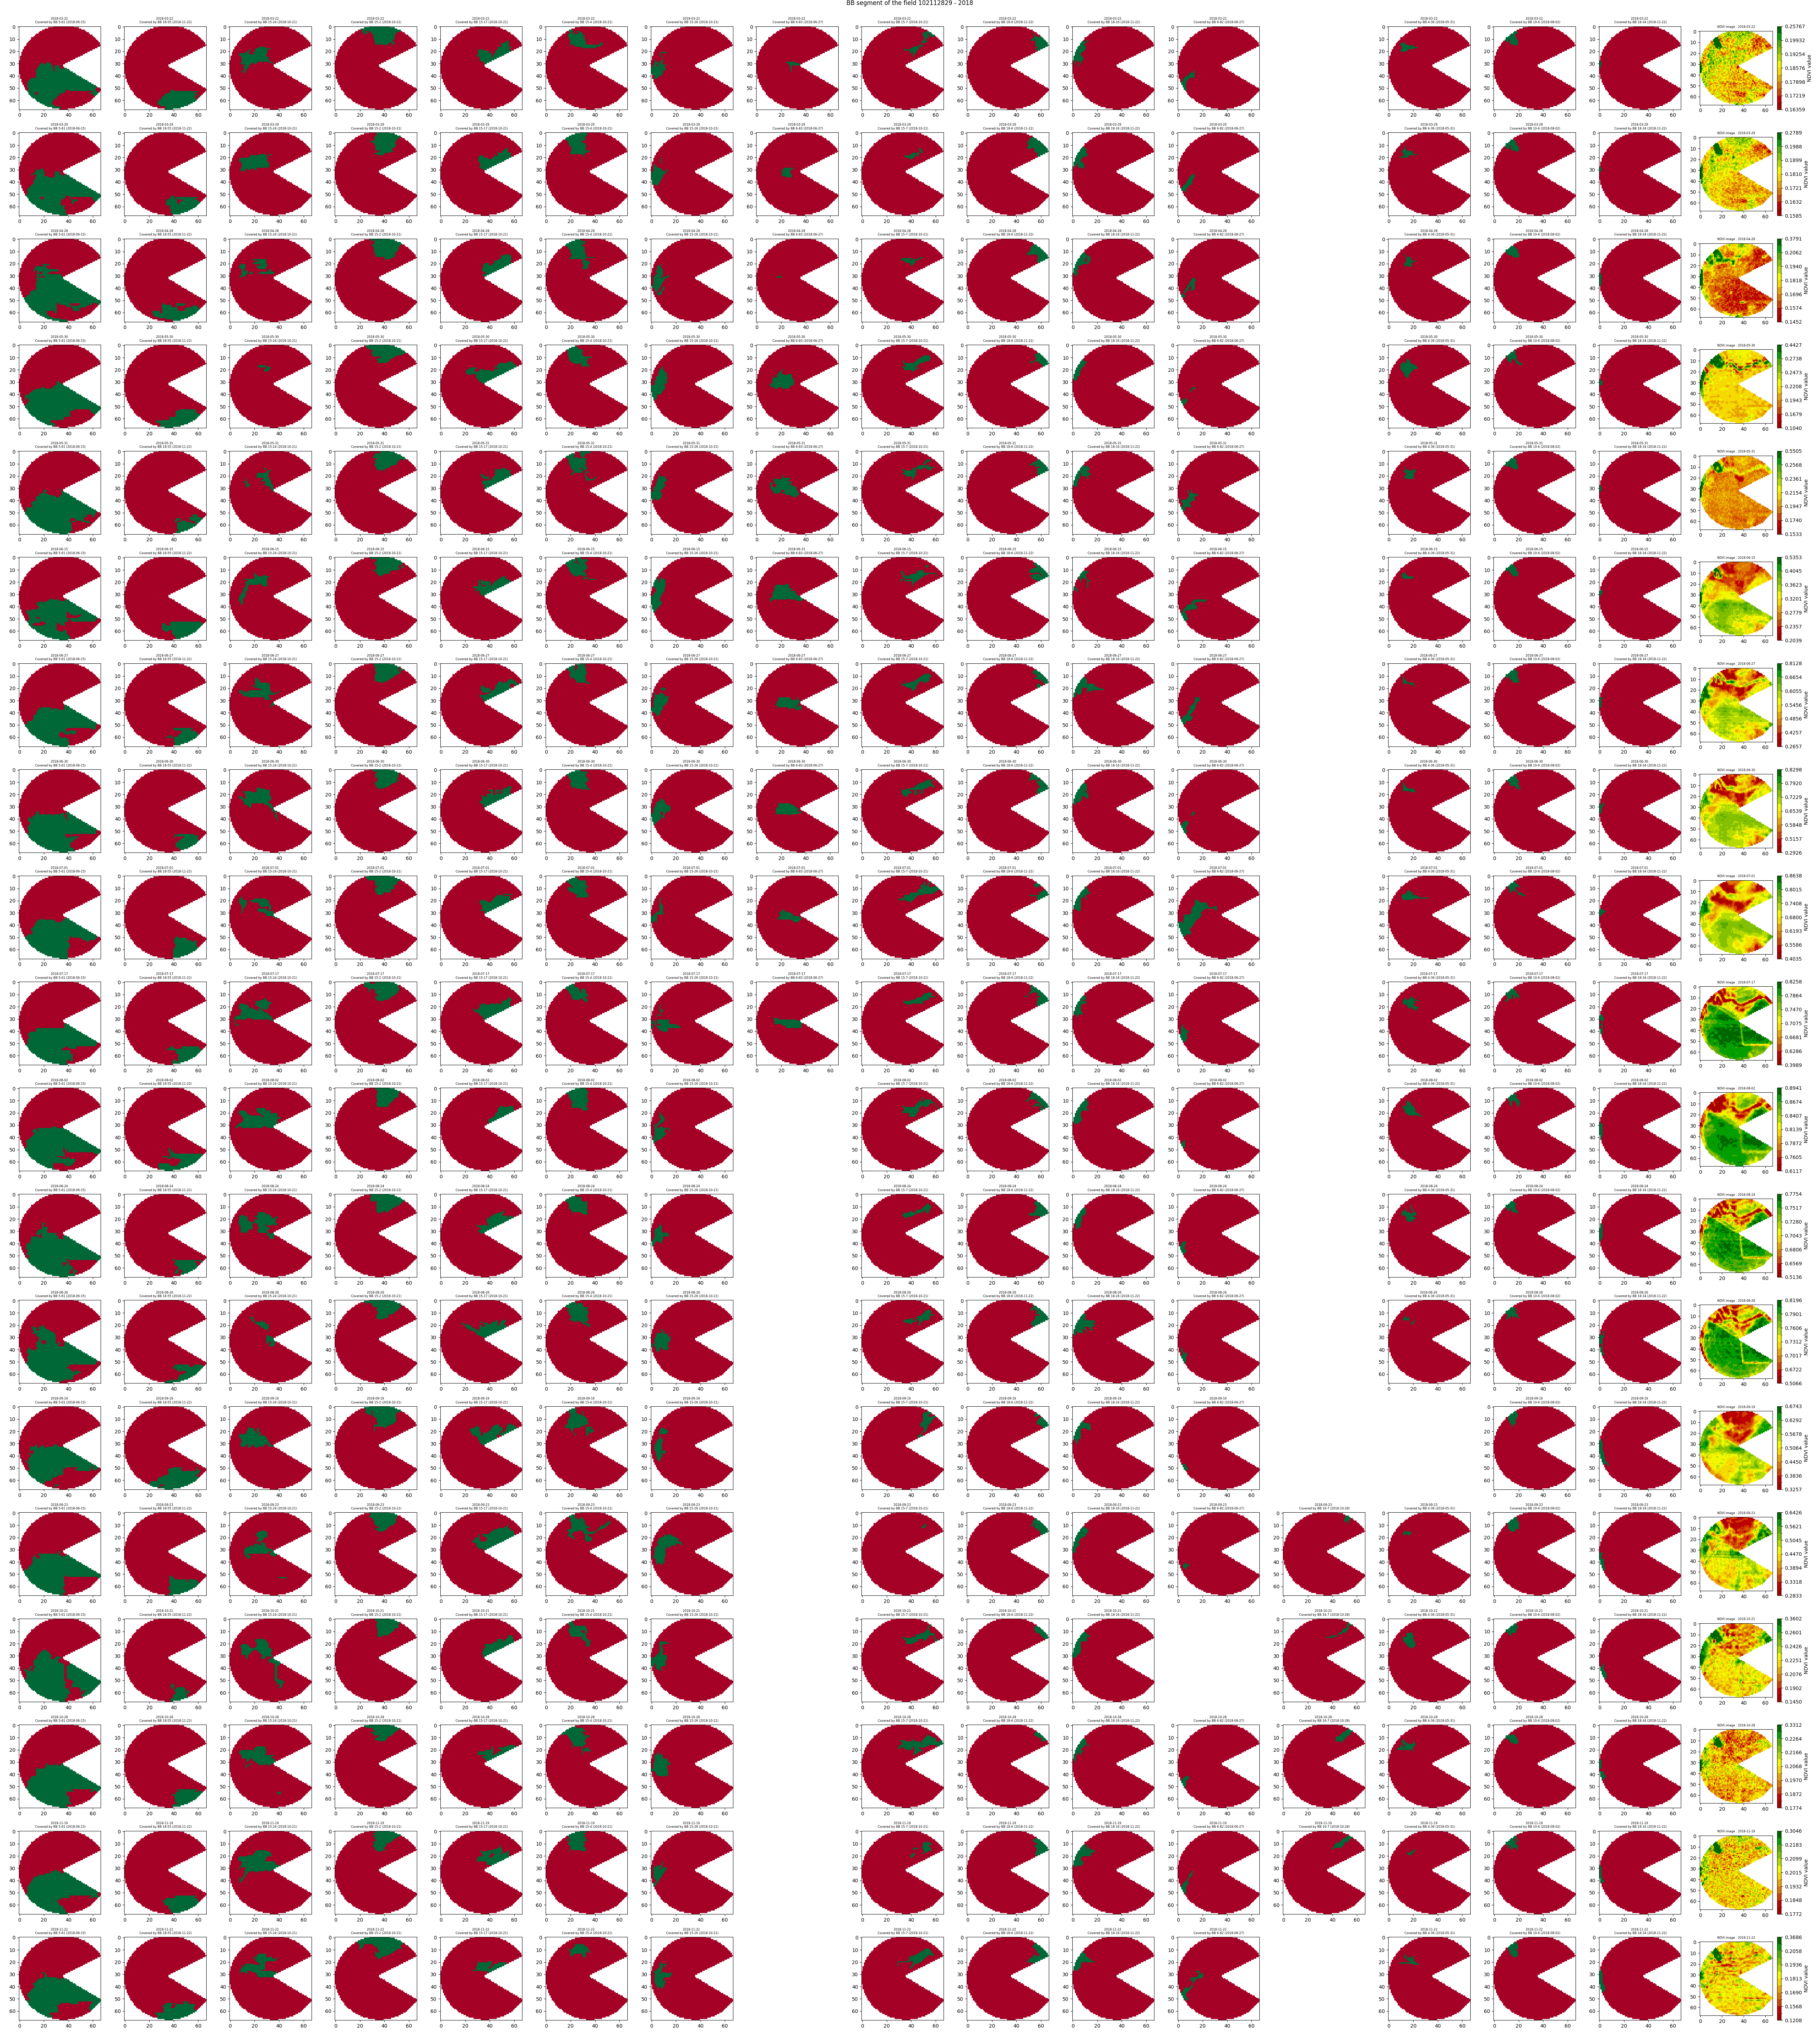

In [19]:
fig = plt.figure(figsize=(3*(bb_final_list.shape[0]+1),3*len(segments_test))) 

for j in range(len(segments_test)):
    date_choice = segments_test.index[j].strftime('%Y-%m-%d')
    raster_ndvi_numpy = raster_df.loc[date_choice, 'raster_ndvi_numpy']
    
    plt.subplot(len(segments_test), bb_final_list.shape[0]+1, j*(bb_final_list.shape[0]+1)+bb_final_list.shape[0]+1)
    cmap, norm = get_palette(raster_ndvi_numpy)
    f2 = plt.imshow(raster_ndvi_numpy, cmap=cmap, norm=norm)
    plt.colorbar(f2, label='NDVI value')
    plt.title(f"NDVI image : {date_choice}",fontsize=6)   
        
for i in range(bb_final_list.shape[0]):
    dico_bb = dict()
    for x in bb_final_list[i,4]:
        dico_bb[x[0]] = dico_bb.get(x[0], []) + [x[1]]
    dico_bb[bb_final_list[i,0]] = [bb_final_list[i,1]]
    dico_bb = dict(sorted(dico_bb.items(), key=operator.itemgetter(0)))
    BB_date = segments_test.index[bb_final_list[i,0]].strftime('%Y-%m-%d')

    for idx in range(len(segments_test)):

        date_choice = segments_test.index[idx].strftime('%Y-%m-%d')
        segments_fz = raster_df.loc[date_choice, 'segments_fz']
        raster_ndvi_numpy = raster_df.loc[date_choice, 'raster_ndvi_numpy']
        coordinate = np.ma.zeros(segments_fz.shape)

        if idx in dico_bb.keys():
            for ind in dico_bb[idx]:
                coordinate[segments_fz == ind] =100
            coordinate.mask = raster_ndvi_numpy.mask

            title = f"{date_choice} \n Covered by BB {bb_final_list[i,0]}-{bb_final_list[i,1]} ({BB_date})"
            cmap = 'RdYlGn'
            if coordinate.min() == 100:
                title = f"{date_choice} \n Totally covered by BB {bb_final_list[i,0]}-{bb_final_list[i,1]} ({BB_date})"
                cmap = colors.ListedColormap(['green'])
            plt.subplot(len(segments_test),bb_final_list.shape[0]+1, idx*(bb_final_list.shape[0]+1)+i+1)
            plt.imshow(coordinate, cmap=cmap)
            plt.title(title, fontsize=6, y=1.0)
            

plt.suptitle(f'BB segment of the field {sfd_id_choice} - {year_choice}', y=1)
plt.tight_layout()
plt.show()